In [167]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf


from math import ceil
import re
import warnings
warnings.filterwarnings('ignore')

In [142]:
pd.set_option('display.max_columns', None)

%matplotlib inline

### Functions

In [143]:
# info about dataframe
def get_info(df):
    info_df = pd.DataFrame()
    info_df['col_name'] = df.columns.to_list()
    info_df['dtype'] = df.dtypes.to_list()
    info_df['missing_values'] = df.isna().sum().to_list()
    info_df['unique_vals'] = df.nunique().to_list()
    info_df['total_vals'] = df.shape[0]
    return info_df

## Data preprocessing
### CPI
CPI - corruption perceptions index 

In [144]:
cpi_df = pd.read_excel('pet-projects/CPI2021_GlobalResults&Trends.xlsx', sheet_name='CPI Timeseries 2012 - 2021', header=[2])
cpi_df.head(2)

,Country / Territory,ISO3,Region,CPI score 2021,Rank 2021,Sources 2021,Standard error 2021,CPI score 2020,Rank 2020,Sources 2020,Standard error 2020,CPI score 2019,Rank 2019,Sources 2019,Standard error 2019,CPI score 2018,Rank 2018,Sources 2018,Standard error 2018,CPI score 2017,Rank 2017,Sources 2017,Standard error 2017,CPI score 2016,Sources 2016,Standard error 2016,CPI score 2015,Sources 2015,Standard error 2015,CPI score 2014,Sources 2014,Standard error 2014,CPI Score 2013,Sources 2013,Standard error 2013,CPI Score 2012,Sources 2012,Standard error 2012
0,Denmark,DNK,WE/EU,88.0,1.0,8.0,1.850507,88.0,1.0,8.0,1.775809,87.0,1.0,8.0,2.542474,88.0,1.0,8.0,2.63,88.0,2.0,8.0,2.75,90.0,7.0,2.46,91.0,7.0,2.16,92.0,7.0,2.04,91.0,7.0,2.2,90.0,7.0,2.0
1,New Zealand,NZL,AP,88.0,1.0,8.0,1.427644,88.0,1.0,8.0,1.479342,87.0,1.0,8.0,2.286490,87.0,2.0,8.0,2.44,89.0,1.0,8.0,2.40,90.0,7.0,2.56,91.0,7.0,2.32,91.0,7.0,2.28,91.0,7.0,2.3,90.0,7.0,2.2


In [145]:
# reshaping and cleaning data (намеренно сложный алгоритм)

cpi_df = cpi_df[[x for x in cpi_df.columns.to_list() if (x.startswith('Country') | x.startswith('CPI'))]].rename(columns={'Country / Territory': 'Countries'})
cpi_df = cpi_df.melt(id_vars=['Countries']).rename(columns={'variable': 'year', 'value': 'cpi'})
cpi_df['year'] = cpi_df.year.apply(lambda x: int(x.strip().split()[-1]))
cpi_df = cpi_df[cpi_df.year == 2020].drop(columns='year').reset_index(drop=True)
cpi_df.head(2)

,Countries,cpi
0,Denmark,88.0
1,New Zealand,88.0


## EFOTW
Economic Freedom of the World

In [146]:
efotw = pd.read_excel('pet-projects/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Data 2022 Report',
                      header=[4])
efotw.head(2)

,Unnamed: 0,Year,ISO Code 2,ISO Code 3,Countries,Economic Freedom Summary Index,Rank,Quartile,1A Government Consumption,data,1B Transfers and subsidies,data.1,1C Government investment,data.2,1Di Top marginal income tax rate,data.3,1Dii Top marginal income and payroll tax rate,data.4,1D Top marginal tax rate,IE State Ownership of Assets,1 Size of Government,2A Judicial independence,2B Impartial courts,2C Protection of property rights,2D Military interference in rule of law and politics,2E Integrity of the legal system,2F Legal enforcement of contracts,2G Regulatory restrictions on the sale of real property,2H Reliability of police,Gender Legal Rights Adjustment,2 Legal System & Property Rights,3A Money growth,data.5,3B Standard deviation of inflation,data.6,3C Inflation: Most recent year,data.7,3D Freedom to own foreign currency bank accounts,3 Sound Money,4Ai Revenue from trade taxes (% of trade sector),data.8,4Aii Mean tariff rate,data.9,4Aiii Standard deviation of tariff rates,data.10,4A Tariffs,4Bi Non-tariff trade barriers,4Bii Compliance costs of importing and exporting,4B Regulatory trade barriers,4C Black market exchange rates,4Di Financial Openness,4Dii Capital controls,4Diii Freedom of foreigners to visit,4D Controls of the movement of capital and people,4 Freedom to trade internationally,5Ai Ownership of banks,5Aii Private sector credit,5Aiii Interest rate controls/negative real interest rates),5A Credit market regulations,5Bi Hiring regulations and minimum wage,5Bii Hiring and firing regulations,5Biii Centralized collective bargaining,5Biv Hours Regulations,5Bv Mandated cost of worker dismissal,5Bvi Conscription,5B Labor market regulations,5Ci Administrative requirements,5Cii Regulatory Burden,5Ciii Starting\na business,5Civ Impartial Public Administration,5Cv Licensing restrictions,5Cvi Tax compliance,5C Business regulations,5 Regulation,Region,World Bank Region,"World Bank Current Income Classification, 1990-present",Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110
0,NaN,2020,AL,ALB,Albania,7.64,26.0,1.0,8.026471,12.71,6.978202,11.590000,7.545714,23.59,9.0,23,7.0,34,8.0,8.5350,7.817077,4.194511,4.073332,3.841150,8.333333,5.40375,3.913506,6.715384,5.607842,1.000000,5.260351,9.783394,1.083032,9.693881,0.765299,9.6758,1.621,10.0,9.788269,9.573333,0.64,9.28,3.6,8.0848,4.788,8.979378,6.807307,9.405328,8.106317,10.000000,4.168718,4.615385,8.6288,5.804301,8.222499,10.0,3.768482,10.0,7.922827,5.566667,4.865385,5.575783,8.0,6.299741,10.0,6.717929,5.651538,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,Eastern Europe,Europe & Central Asia,UM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970.0,1975.0,1980.0,1985.0,1990.0,1995.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
1,NaN,2020,DZ,DZA,Algeria,5.12,157.0,4.0,3.102941,29.45,7.817129,8.511137,3.997143,36.01,7.0,35,2.0,53,4.5,2.6325,4.409943,4.091589,4.040832,5.129855,3.333333,4.79125,4.392092,6.626692,6.347414,0.705882,4.131760,8.007512,9.962438,7.996637,5.008408,9.5170,2.415,5.0,7.630287,8.480000,2.28,6.22,18.9,5.9176,10.206,6.872533,4.557608,0.479290,2.518449,4.362819,1.643452,0.769231,0.0000,0.804228,3.639507,0.0,8.014124,10.0,6.004708,5.566667,5.028064,6.522477,6.0,7.755176,3.0,5.645397,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,Middle East & North Africa,Middle East & North Africa,LM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,106.0,111.0,113.0,117.0,123.0,125.0,123.0,123.0,127.0,130.0,141.0,141.0,141.0,141.0,141.0,153.0,153.0,153.0,157.0,159.0,159.0,162.0,162.0,162.0,165.0,165.0


In [147]:
efotw = efotw[efotw.Year == 2020][['Countries', 'Economic Freedom Summary Index']]
efotw.head(2)

,Countries,Economic Freedom Summary Index
0,Albania,7.64
1,Algeria,5.12


### Democracy-dictatorship

In [148]:
democracy = pd.read_csv('pet-projects/democracy_dictatorship by country.csv', encoding='cp1252', sep=';')
democracy.head(2)

,Country_Code,Country_Name,Population,Type,Subtype
0,ALB,Albania,2878420,Democracy,1. Parliamentary Democracy
1,AND,Andorra,77240,Democracy,1. Parliamentary Democracy


In [149]:
democracy.Subtype.unique()

array(['1. Parliamentary Democracy', '2. Presidential Democracy',
       '3. Semi-Presidential Democracy', '5. Civilian Dictatorship',
       '4. Royal Dictatorship', '6. Military Dictatorship'], dtype=object)

In [150]:
democracy = democracy.rename(columns={'Country_Name': 'Countries'}).iloc[:,[1, 2, 3, 4]]
democracy.Subtype = democracy.Subtype.apply(lambda x: x.strip().replace(' ', '_').replace('-', '_').lower()[3:])
democracy.Type = democracy.Type.apply(lambda x: x.lower())

In [151]:
democracy.head(2)

,Countries,Population,Type,Subtype
0,Albania,2878420,democracy,parliamentary_democracy
1,Andorra,77240,democracy,parliamentary_democracy


### World happiness index

In [152]:
happiness = pd.read_csv('pet-projects/world-happiness-report-2021.csv')
happiness.head(2)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868


In [153]:
happiness = happiness[['Country name', 'Ladder score', 'Logged GDP per capita', 'Social support',
                       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity']]\
                    .rename(columns={'Country name': 'Countries'})
happiness.head(2)

,Countries,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030


### Resulting dataframe

In [154]:
regimes = happiness.merge(cpi_df, how='left', on='Countries')\
                   .merge(efotw, how='left', on='Countries')\
                   .merge(democracy, how='left', on='Countries')
regimes.head(2)

,Countries,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,cpi,Economic Freedom Summary Index,Population,Type,Subtype
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,85.0,7.64,5539002.0,democracy,semi_presidential_democracy
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,88.0,8.09,5788108.0,democracy,parliamentary_democracy


In [155]:
regimes.columns = list(map(lambda x: x.strip().replace(' ', '_').lower(), regimes.columns))
regimes.rename(columns={'ladder_score': 'happiness_score'}, inplace=True)
regimes['population_log'] = np.log(regimes.population)

regimes_info = get_info(regimes)
regimes_info

,col_name,dtype,missing_values,unique_vals,total_vals
0,countries,object,0,149,149
1,happiness_score,float64,0,147,149
2,logged_gdp_per_capita,float64,0,148,149
3,social_support,float64,0,119,149
4,healthy_life_expectancy,float64,0,135,149
5,freedom_to_make_life_choices,float64,0,126,149
6,generosity,float64,0,130,149
7,cpi,float64,10,52,149
8,economic_freedom_summary_index,float64,22,101,149
9,population,float64,11,138,149


Great! There is some raws with missing values and mostly raws with no missing values. Let's visualize data to figure out probability density distribution type.

In [156]:
# full version (with NaN vals) of the regimes_df
regimes_full = regimes.copy()
# version without NaN vals
regimes = regimes.dropna().reset_index(drop=True)

### Normality test

In [157]:
# probability density distribution exploration
def density_distribution(data_column, conf_level:float, plot_title:str, show_info=True):
#   quantiles
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level)/2
    quants = data_column.quantile([left_quant, right_quant])

#   visualization
    if show_info is True:    
        plt.figure(figsize=(12, 5))
        fig_1 = plt.subplot(1, 2, 1)
        _, _, bars = plt.hist(data_column, bins = 30)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0] or bar.get_x() >= quants.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.vlines(quants,ymin=0,ymax=15,linestyle='--')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.title(f'{plot_title}\n')
        fig_2 = plt.subplot(1, 2, 2)
        ss.probplot(data_column, plot=plt)
        plt.title(f'{plot_title} QQ-plot\n')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.show()
    
#   Shapiro and D'Agostino normtest
    shapiro_result = ss.shapiro(data_column)
    dagostino_result = ss.normaltest(data_column)
    if ((shapiro_result[1] >= 0.05) & (dagostino_result[1] >= 0.05)):
        if show_info is True:
            print(f'{plot_title} has normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}' )
        return True
    else:
        if show_info is True:
            print(f'{plot_title} has not normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}')
        return False

In [158]:
normal = []
not_normal = []
for column in regimes.columns.to_list():
    if regimes[column].dtype == float:
        if not density_distribution(data_column=regimes[column], conf_level=0.95, plot_title=column, show_info=False):
            not_normal.append(column)
        else:
            normal.append(column)
            
not_normal

['logged_gdp_per_capita',
 'social_support',
 'healthy_life_expectancy',
 'freedom_to_make_life_choices',
 'generosity',
 'cpi',
 'economic_freedom_summary_index',
 'population']

In [159]:
normal

['happiness_score', 'population_log']

So, we can see that only HAPPINESS SCORE has normal distribution. Let's look another 8 parameters.

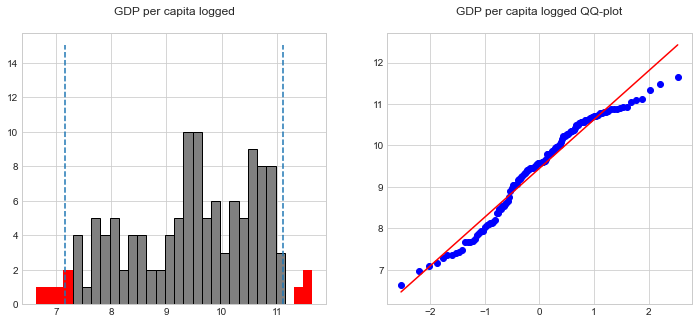

GDP per capita logged has not normal probability density distribution
 Shapiro test p-val 0.001198930898681283
 Dagostino p-val 0.003994225332335143


False

In [160]:
density_distribution(data_column=regimes.logged_gdp_per_capita, conf_level=0.95, plot_title='GDP per capita logged')

### Correlation

Let's implement correlation test using Spearman, Pearson tests and Linear-regression test to figure out does it exist correlation between dependent variable (healthy_life_expectancy) and independent variables?

In [211]:
def corr_test(df, dep_var:str, indep_vars=None):
    if (indep_vars is None) & (type(dep_var) == str):
        indep_vars = list(filter(lambda column: column != dep_var, regimes._get_numeric_data().columns.to_list()))
    elif (indep_vars is None) & (type(dep_var) != str):
        indep_vars = list(filter(lambda column: column != dep_var.name, regimes._get_numeric_data().columns.to_list()))
    elif (type(indep_vars) != list) & (type(indep_vars) != str):
        indep_vars = indep_vars.columns.to_list()
    elif type(indep_vars) == str:
        lst = []
        lst.append(indep_vars)
        indep_vars = lst
    if type(dep_var) == str:
        dep_var = df[dep_var]
    corr_df = pd.DataFrame(index=indep_vars, columns=[['spearman_corr', 'spearman_sign', 'pearson_corr', 'pearson_sign', 'linear_corr', 'linear_sign']])
    for var in indep_vars:
        corr_df.loc[var, 'spearman_corr'] = round(ss.spearmanr(dep_var, df[var])[0], 2)
        corr_df.loc[var, 'spearman_sign'] = np.where(ss.spearmanr(dep_var, df[var])[1] < 0.05, 'significant', 'not significant')
        corr_df.loc[var, 'pearson_corr'] = round(ss.pearsonr(dep_var, df[var])[0], 2)
        corr_df.loc[var, 'pearson_sign'] = np.where(ss.pearsonr(dep_var, df[var])[1] < 0.05, 'significant', 'not significant')
        corr_df.loc[var, 'linear_corr'] = round(ss.linregress(dep_var, df[var])[2], 2)
        corr_df.loc[var, 'linear_sign'] = np.where(ss.linregress(dep_var, df[var])[3] < 0.05, 'significant', 'not significant')
    styled_corr_df = corr_df.style.applymap(lambda x: "background-color: pink" if x=='not significant' 
                                            else "background-color: white").format_index(lambda x: x[0], axis=1)
    return styled_corr_df
    


def linear_visualization(df, dep_var:str, indep_vars=None):
    if (indep_vars is None) & (type(dep_var) == str):
        indep_vars = list(filter(lambda column: column != dep_var, regimes._get_numeric_data().columns.to_list()))
    elif (indep_vars is None) & (type(dep_var) != str):
        indep_vars = list(filter(lambda column: column != dep_var.name, regimes._get_numeric_data().columns.to_list()))
    elif (type(indep_vars) != list) & (type(indep_vars) != str):
        indep_vars = indep_vars.columns.to_list()
    elif type(indep_vars) == str:
        lst = []
        lst.append(indep_vars)
        indep_vars = lst
    if type(dep_var) == str:
        dep_var = df[dep_var]
    
    plt.figure(figsize=(15, 1.5*len(indep_vars)))
    for i, indep_var in enumerate(indep_vars):
        i += 1
        ax = plt.subplot(ceil(len(indep_vars)/3) , 3, i)
        sns.regplot(data=df, x=indep_var, y=dep_var)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        ax.set(yticklabels=[], xticklabels=[])
        plt.title('\n' + indep_var.capitalize().replace('_', ' '))

    plt.show()

    
def vif(df, dep_var, indep_vars=None):
    if (indep_vars is None) & (type(dep_var) == str):
        indep_vars = list(filter(lambda column: column != dep_var, df._get_numeric_data().columns.to_list()))
    elif (indep_vars is None) & (type(dep_var) != str):
        indep_vars = list(filter(lambda column: column != dep_var.name, df._get_numeric_data().columns.to_list()))
    elif (type(indep_vars) != list) & (type(indep_vars) != str):
        indep_vars = indep_vars.columns.to_list()
    elif type(indep_vars) == str:
        lst = []
        lst.append(indep_vars)
        indep_vars = lst
    if type(dep_var) != str:
        dep_var = dep_var.name
    # gather features
    features = " + ".join(list(filter(lambda x: x !=dep_var, indep_vars)))

    # get y and X dataframes based on this regression:
    y, X = dmatrices(dep_var + ' ~ ' + features, data=df._get_numeric_data(), return_type='dataframe')

    vif = pd.DataFrame()
    vif['VIF factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns

    return vif.round(1)

In [212]:
# Spearman, Pearson and Linear-regression correlation tests

corr_test(regimes, regimes.healthy_life_expectancy)

,spearman_corr,spearman_sign,pearson_corr,pearson_sign,linear_corr,linear_sign
happiness_score,0.830000,significant,0.800000,significant,0.800000,significant
logged_gdp_per_capita,0.870000,significant,0.870000,significant,0.870000,significant
social_support,0.770000,significant,0.750000,significant,0.750000,significant
freedom_to_make_life_choices,0.500000,significant,0.480000,significant,0.480000,significant
generosity,-0.160000,not significant,-0.200000,significant,-0.200000,significant
cpi,0.730000,significant,0.690000,significant,0.690000,significant
economic_freedom_summary_index,0.690000,significant,0.650000,significant,0.650000,significant
population,-0.180000,not significant,-0.030000,not significant,-0.030000,not significant
population_log,-0.180000,not significant,-0.160000,not significant,-0.160000,not significant


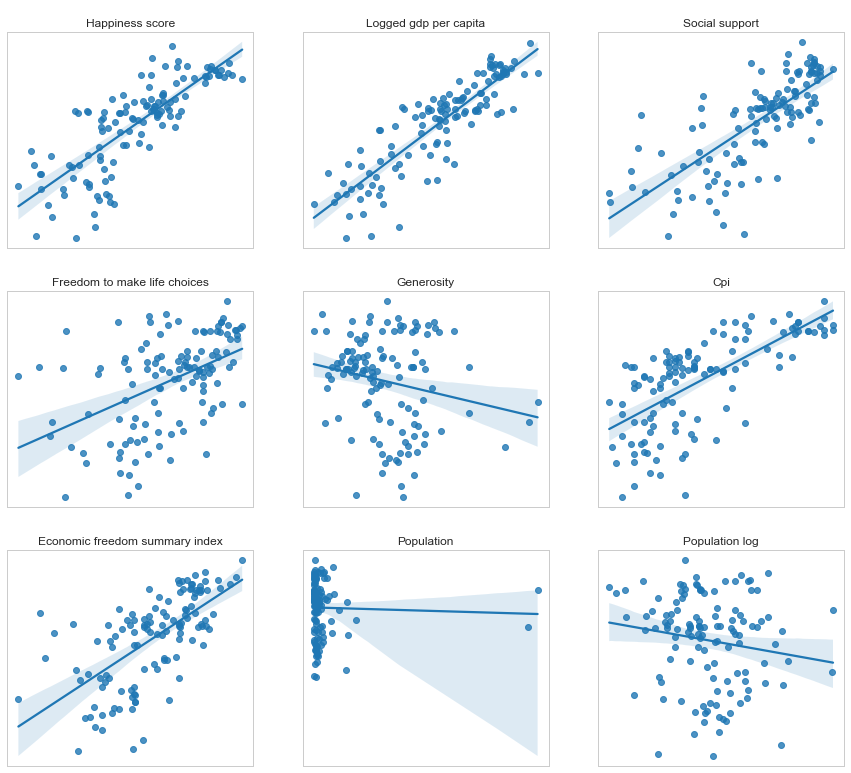

In [213]:
# Linear regression visualization

linear_visualization(df=regimes, dep_var='healthy_life_expectancy')

__The Variance Inflation Factor (VIF) calculation for detecting multicolinearity__

We are interested in the healthy_life_expectancy correlation with other variables. This parameter is selected like a dependent variable.

In [214]:
vif(regimes, regimes.healthy_life_expectancy)

,VIF factor,features
0,481.7,Intercept
1,4.3,happiness_score
2,6.0,logged_gdp_per_capita
3,3.8,social_support
4,1.8,freedom_to_make_life_choices
5,1.2,generosity
6,3.0,cpi
7,2.6,economic_freedom_summary_index
8,1.6,population
9,1.7,population_log


It is assumed that VIF greater than 5 indicates multicolinearity. There is only one position with VIF greater than 5 (logged_gdp_per_capita), but there's no reason to assume that it's multicolinearity in fact, rather these variables are highly correlated but they do not "explain" the same variance in this dataset. But we can use some other more appropriate for data with multicolinearity linear model (like Ridge-regression, Lasso-regression etc.) if we suppose multicolinearity in data exists.

In [268]:
# transformation of categorical data to prepare for linear regression
dummy_regimes = pd.get_dummies(regimes.iloc[:,1:-2], drop_first=True)
dummy_regimes = dummy_regimes.drop(columns=['population', 'social_support', 'cpi',
                                            'freedom_to_make_life_choices', 'type_dictatorship'])

In [271]:
Y = 'healthy_life_expectancy'
X = ' + '.join(filter(lambda x: x != 'healthy_life_expectancy', dummy_regimes.columns.to_list()))
params = Y + ' ~ ' + X

result = smf.ols(params, dummy_regimes).fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     healthy_life_expectancy   R-squared:                       0.791
Model:                                 OLS   Adj. R-squared:                  0.784
Method:                      Least Squares   F-statistic:                     111.4
Date:                     Mon, 12 Dec 2022   Prob (F-statistic):           4.08e-39
Time:                             00:39:52   Log-Likelihood:                -311.35
No. Observations:                      123   AIC:                             632.7
Df Residuals:                          118   BIC:                             646.8
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------